In [1]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import numpy as np
import math

gas_factor = 15

file_list = ("Arith", "./monte_carlo_arith_deterministic_parallel_unfiltered_2.csv")

def get_df(file):
    (name, path) = file;
    df = pd.read_csv(path)
        
    return df

data = get_df(file_list)

data.head()

,modulus_limbs,group_limbs,num_mul_pairs,a_is_zero,ext_degree,run_microseconds_add,run_microseconds_mul,run_microseconds_multiexp
0,4,1,128,0,1,89,86,1277
1,4,1,128,0,3,136,635,11179
2,4,1,64,0,1,17,69,743
3,4,1,64,0,3,84,567,6558
4,4,1,32,0,1,17,60,392


In [2]:
from sklearn import linear_model
from sklearn.linear_model import Lasso
from scipy.optimize import nnls

def split(df):
    g1 = df[df["ext_degree"] == 1]
    g1_a_non_zero = g1[g1["a_is_zero"] == 0].copy()
    g1_a_is_zero = g1[g1["a_is_zero"] == 1].copy()
    
    g2_ext_2 = df[df["ext_degree"] == 2]
    g2_ext_2_a_non_zero = g2_ext_2[g2_ext_2["a_is_zero"] == 0].copy()
    g2_ext_2_a_is_zero = g2_ext_2[g2_ext_2["a_is_zero"] == 1].copy()
    
    g2_ext_3 = df[df["ext_degree"] == 3]
    g2_ext_3_a_non_zero = g2_ext_3[g2_ext_3["a_is_zero"] == 0].copy()
    g2_ext_3_a_is_zero = g2_ext_3[g2_ext_3["a_is_zero"] == 1].copy()
    
    
    return (g1_a_non_zero, g1_a_is_zero, g2_ext_2_a_non_zero, g2_ext_2_a_is_zero, g2_ext_3_a_non_zero, g2_ext_3_a_is_zero)

(g1_a_non_zero, g1_a_is_zero, g2_ext_2_a_non_zero, g2_ext_2_a_is_zero, g2_ext_3_a_non_zero, g2_ext_3_a_is_zero) = split(data)

g1_a_non_zero.head()


,modulus_limbs,group_limbs,num_mul_pairs,a_is_zero,ext_degree,run_microseconds_add,run_microseconds_mul,run_microseconds_multiexp
0,4,1,128,0,1,89,86,1277
2,4,1,64,0,1,17,69,743
4,4,1,32,0,1,17,60,392
6,4,1,16,0,1,9,53,307
8,4,1,8,0,1,9,51,153


In [3]:
def make_diffs(non_zero, is_zero):
    diff = non_zero.copy();
    diff["run_microseconds_add"] -= is_zero["run_microseconds_add"]
    diff["run_microseconds_mul"] -= is_zero["run_microseconds_mul"]
    diff["run_microseconds_multiexp"] -= is_zero["run_microseconds_multiexp"]
    
    return diff
    
diff = make_diffs(g1_a_non_zero, g1_a_is_zero)

g1_a_is_zero.head()

# diff.head()

,modulus_limbs,group_limbs,num_mul_pairs,a_is_zero,ext_degree,run_microseconds_add,run_microseconds_mul,run_microseconds_multiexp
14,4,1,128,1,1,12,46,946
16,4,1,64,1,1,9,46,590
18,4,1,32,1,1,9,50,364
20,4,1,16,1,1,10,52,246
22,4,1,8,1,1,9,52,171


In [4]:
def fit_add_and_mul(df):
    addition = df[["modulus_limbs","run_microseconds_add"]].groupby(['modulus_limbs']).mean()
    addition["gas_add"] = addition["run_microseconds_add"].apply(lambda x: gas_factor * math.ceil(x))
    addition.drop('run_microseconds_add', axis=1, inplace=True)
#     addition = df[["modulus_limbs","run_microseconds_add"]].groupby(['modulus_limbs']).median()
    multiplication = df[["modulus_limbs","group_limbs", "run_microseconds_mul"]].groupby(['modulus_limbs', 'group_limbs']).mean()
#     multiplication = df[["modulus_limbs","group_limbs", "run_microseconds_mul"]].groupby(['modulus_limbs', 'group_limbs']).median()
    
    return (addition.copy(), multiplication.copy())

(g1_add_is_zero, g1_m_is_zero) = fit_add_and_mul(g1_a_is_zero)
(g1_add_non_zero, g1_m_non_zero) = fit_add_and_mul(g1_a_non_zero)

In [48]:
def merge_max(non_zero, zero):
    result = non_zero.copy()
    result["gas_add_non_zero"] = result["gas_add"]
    result.drop("gas_add", axis = 1, inplace = True)
    result["gas_add_zero"] = zero["gas_add"]
    result["gas_add"] = result[["gas_add_non_zero", "gas_add_zero"]].apply(lambda x: max(x["gas_add_non_zero"], x["gas_add_zero"]), axis=1)
    result.drop("gas_add_non_zero", axis = 1, inplace = True)
    result.drop("gas_add_zero", axis = 1, inplace = True)
    result.reset_index(inplace = True)

    return result

In [6]:
def merge_max_mul(this, other):
    result = this.copy()
    result["base_1"] = result["base_gas"]
    result.drop("base_gas", axis = 1, inplace = True)
    result["base_2"] = other["base_gas"]
    result["base_gas"] = result[["base_1", "base_2"]].max(axis = 1)
    
    result["gas_per_group_limb_1"] = result["gas_per_group_limb"]
    result.drop("gas_per_group_limb", axis = 1, inplace = True)
    result["gas_per_group_limb_2"] = other["gas_per_group_limb"]
    result["gas_per_group_limb"] = result[["gas_per_group_limb_1", "gas_per_group_limb_2"]].max(axis = 1)
    
    result.drop("base_1", axis = 1, inplace = True)
    result.drop("base_2", axis = 1, inplace = True)
    
    result.drop("gas_per_group_limb_1", axis = 1, inplace = True)
    result.drop("gas_per_group_limb_2", axis = 1, inplace = True)

    return result

In [49]:
g1_add = merge_max(g1_add_non_zero, g1_add_is_zero)

g1_add.head(15)

,modulus_limbs,gas_add
0,4,195
1,5,240
2,6,300
3,7,345
4,8,450
5,9,510
6,10,630
7,11,690
8,12,795
9,13,900


In [8]:
def fit_mul(df):
    
    results = []
    for limbs, g in df.groupby(["modulus_limbs"]):
        g = g.copy()
        g.reset_index(inplace=True) 
        model = Lasso(alpha=0.0001,precompute=True,max_iter=1000,
            positive=True, random_state=9999, selection='random')
        model.fit(g["group_limbs"][:, np.newaxis], g["run_microseconds_mul"][:, np.newaxis])

        score = model.score(g["group_limbs"][:, np.newaxis], g["run_microseconds_mul"][:, np.newaxis])

        print("R^2 = {}".format(score))

        slope = math.ceil(model.coef_[0]) * gas_factor;
        intercept = math.ceil(model.intercept_[0]) * gas_factor;
        
        results.append([limbs, slope, intercept])
        
    result_df = pd.DataFrame(results, columns = ["modulus_limbs", "gas_per_group_limb", "base_gas"])
    
    return result_df

In [9]:
results_mul_g1 = merge_max_mul(fit_mul(g1_m_is_zero), fit_mul(g1_m_non_zero))

results_mul_g1.head(16)

R^2 = 0.9999199936781422
R^2 = 0.9999674526370343
R^2 = 0.9999771345266874
R^2 = 0.9999888222510447
R^2 = 0.9999952424642169
R^2 = 0.9999679461940769
R^2 = 0.9999331062109333
R^2 = 0.9999955793751287
R^2 = 0.9999559773473287
R^2 = 0.999934525706301
R^2 = 0.9999890301237453
R^2 = 0.9998609648502375
R^2 = 0.9987923061402163
R^2 = 0.9999020953454828
R^2 = 0.999976396595164
R^2 = 0.9999676714718104
R^2 = 0.9999923169679507
R^2 = 0.9999940981554523
R^2 = 0.9999635128134116
R^2 = 0.999934797498945
R^2 = 0.9999943017274658
R^2 = 0.9999356231897188
R^2 = 0.9999314031037259
R^2 = 0.9999896109828192
R^2 = 0.9998630205164802
R^2 = 0.9987490335588167


,modulus_limbs,base_gas,gas_per_group_limb
0,4,180,870
1,5,255,1185
2,6,285,1500
3,7,285,1890
4,8,375,2370
5,9,375,3030
6,10,375,3585
7,11,660,4170
8,12,660,4905
9,13,540,5655


In [10]:
(g2_ext2_add_is_zero, g2_ext2_m_is_zero) = fit_add_and_mul(g2_ext_2_a_is_zero)
(g2_ext2_add_non_zero, g2_ext2_m_non_zero) = fit_add_and_mul(g2_ext_2_a_non_zero)

In [50]:
g2_ext2_add = merge_max(g2_ext2_add_non_zero, g2_ext2_add_is_zero)

g2_ext2_add.head(15)

,modulus_limbs,gas_add
0,4,1170
1,5,1665
2,6,2205
3,7,2835
4,8,3615
5,9,4365
6,10,5325
7,11,6360
8,12,7500
9,13,8670


In [12]:
results_mul_g2_ext_2 = merge_max_mul(fit_mul(g2_ext2_m_is_zero), fit_mul(g2_ext2_m_non_zero))

results_mul_g2_ext_2.head(16)

R^2 = 0.9999032316127509
R^2 = 0.9999681308068268
R^2 = 0.9999733740735604
R^2 = 0.9999899395936023
R^2 = 0.9999858908970376
R^2 = 0.9999913834339217
R^2 = 0.999930919383849
R^2 = 0.9999934949846166
R^2 = 0.9999518208815034
R^2 = 0.9999350716384092
R^2 = 0.999982422198231
R^2 = 0.9998627800060036
R^2 = 0.9987468978642111
R^2 = 0.999907823850796
R^2 = 0.9999723156089176
R^2 = 0.9999595991626546
R^2 = 0.9999868513707869
R^2 = 0.9999915820017319
R^2 = 0.9999789320536776
R^2 = 0.9999439514574017
R^2 = 0.9999951358182605
R^2 = 0.9999603153596818
R^2 = 0.9999200939081062
R^2 = 0.9999861347661765
R^2 = 0.9998592050291066
R^2 = 0.9987399838823933


,modulus_limbs,base_gas,gas_per_group_limb
0,4,1035,3960
1,5,1635,5400
2,6,2145,6870
3,7,2565,8580
4,8,3300,10965
5,9,3840,13950
6,10,4080,16590
7,11,6330,19350
8,12,6675,22845
9,13,7170,26280


In [13]:
(g2_ext3_add_is_zero, g2_ext3_m_is_zero) = fit_add_and_mul(g2_ext_3_a_is_zero)
(g2_ext3_add_non_zero, g2_ext3_m_non_zero) = fit_add_and_mul(g2_ext_3_a_non_zero)

In [51]:
g2_ext3_add = merge_max(g2_ext3_add_non_zero, g2_ext3_add_is_zero)

g2_ext3_add.head(15)

,modulus_limbs,gas_add
0,4,1260
1,5,1785
2,6,2310
3,7,2955
4,8,3795
5,9,4665
6,10,5685
7,11,6795
8,12,7995
9,13,9255


In [15]:
results_mul_g2_ext_3 = merge_max_mul(fit_mul(g2_ext3_m_is_zero), fit_mul(g2_ext3_m_non_zero))

results_mul_g2_ext_3.head(16)

R^2 = 0.9999197718103535
R^2 = 0.9999708628457065
R^2 = 0.9999739351080261
R^2 = 0.9999851677238278
R^2 = 0.9999913880198678
R^2 = 0.9999947988864247
R^2 = 0.9999365947841143
R^2 = 0.999995285460228
R^2 = 0.9999441764076454
R^2 = 0.9999326016516054
R^2 = 0.9999900720944419
R^2 = 0.9998795776766173
R^2 = 0.998773195061207
R^2 = 0.9999102084101484
R^2 = 0.9999758729911811
R^2 = 0.9999807178604547
R^2 = 0.9999913732609275
R^2 = 0.9999811736372592
R^2 = 0.9999911420879548
R^2 = 0.9999386440236944
R^2 = 0.9999935048432042
R^2 = 0.9999308028850838
R^2 = 0.999940693177829
R^2 = 0.9999886302339135
R^2 = 0.9998771773996423
R^2 = 0.9987367295348145


,modulus_limbs,base_gas,gas_per_group_limb
0,4,1020,7695
1,5,1830,10320
2,6,2205,13200
3,7,2550,16515
4,8,3420,21195
5,9,4005,27060
6,10,3120,31755
7,11,6735,36825
8,12,6585,43485
9,13,6180,49740


In [16]:
from sklearn import linear_model
from sklearn.linear_model import Lasso
from scipy.optimize import nnls

def correct_and_fit(df, base_costs, skip_bad_fits = False):
    min_score = 1.0
    
    df_miller_loops = pd.DataFrame(columns = df.columns);
    df_miller_loops.drop("num_pairs", axis = 1, inplace = True);
    df_miller_loops.drop("run_microseconds", axis = 1, inplace = True);
    df_miller_loops["miller_gas"] = 0.0
    
    for (k, g) in df.groupby(['modulus_limbs', "group_limbs"]):
        g = g.copy()
        g["gas"] = g["run_microseconds_multiexp"].apply(lambda x: gas_factor * math.ceil(x))
        g.drop("run_microseconds_multiexp", axis = 1, inplace = True)
        g["gas_naive"] = g[["modulus_limbs","group_limbs", "num_pairs"]].apply(lambda x: eval_naive(x["modulus_limbs"], x["group_limbs"], x["group_limbs"], base_costs), axis=1)

        model = Lasso(alpha=0.0001,precompute=True,max_iter=1000,
            positive=True, random_state=9999, selection='random', fit_intercept = False)
        model.fit(g["num_pairs"][:, np.newaxis], g["gas_corrected"][:, np.newaxis])
        
        score = model.score(g["num_pairs"][:, np.newaxis], g["gas_corrected"][:, np.newaxis])
        if score < min_score:
            min_score = score
            
        if score < 0.85 and skip_bad_fits:
#             print(g["num_pairs"])
#             print(g["run_microseconds"])
            continue
            
        slope = model.coef_[0];
        intercept = model.intercept_;
#         intercept = model.intercept_[0];
        
#         if slope <= 1 or intercept <= 1:
#             continue
            
        g_miller = g.iloc[0].copy()
        g_miller.drop("gas_corrected", inplace = True)

        g_miller["miller_gas"] = slope;

        g_miller.drop("num_pairs", inplace = True)
        g_miller.drop("gas", inplace = True)

        df_miller_loops = df_miller_loops.append(g_miller, verify_integrity=True)
        
    print("Min score = {}".format(min_score))
        
    return df_miller_loops



In [34]:
def eval_naive(modulus_limbs, group_limbs, num_pairs, base_costs):
    base = base_costs[base_costs["modulus_limbs"] == modulus_limbs]["base_gas"].array[0]
    per_group_limb = base_costs[base_costs["modulus_limbs"] == modulus_limbs]["gas_per_group_limb"].array[0] * group_limbs
    
    final = num_pairs*(base + per_group_limb)
    
    return final

def estimate_naive(df, base_costs):
    g = df.copy()
    g["gas"] = g["run_microseconds_multiexp"].apply(lambda x: gas_factor * math.ceil(x))
    g.drop("run_microseconds_multiexp", axis = 1, inplace = True)
    g["gas_naive"] = g[["modulus_limbs","group_limbs", "num_mul_pairs"]].apply(lambda x: eval_naive(x["modulus_limbs"], x["group_limbs"], x["num_mul_pairs"], base_costs), axis=1)
    g["gas_factor"] = g[["gas_naive","gas"]].apply(lambda x: x["gas"] * 1.0 / (x["gas_naive"] * 1.0), axis=1)
    factors = g[["num_mul_pairs", "gas_factor"]].groupby(["num_mul_pairs"]).mean()
    factors.reset_index(inplace=True) 
#     factors["log_factor"] = factors["gas_factor"].apply(lambda x: np.log(x))
#     factors = g[["num_mul_pairs", "gas_factor"]].groupby(["num_mul_pairs"]).max()
    return factors

multiexp_g1 = estimate_naive(g1_a_non_zero, fit_mul(g1_m_non_zero))

multiexp_g1.head(15)


R^2 = 0.9999020953454828
R^2 = 0.999976396595164
R^2 = 0.9999676714718104
R^2 = 0.9999923169679507
R^2 = 0.9999940981554523
R^2 = 0.9999635128134116
R^2 = 0.999934797498945
R^2 = 0.9999943017274658
R^2 = 0.9999356231897188
R^2 = 0.9999314031037259
R^2 = 0.9999896109828192
R^2 = 0.9998630205164802
R^2 = 0.9987490335588167


,num_mul_pairs,gas_factor
0,2,0.853026
1,4,0.591602
2,8,0.407704
3,16,0.296348
4,32,0.234606
5,64,0.191359
6,128,0.150962


In [35]:
import matplotlib.pyplot as plt

plt.close('all')

# multiexp_g1.plot(x = "num_mul_pairs", y = "log_factor")

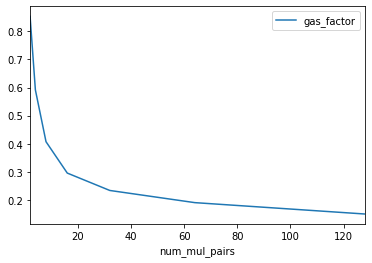

In [36]:
multiexp_g1.plot(x = "num_mul_pairs", y = "gas_factor")

In [42]:
import numpy as np
import scipy

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

def interpolate(df):
    x = df["num_mul_pairs"].to_numpy()
    y = df["gas_factor"].to_numpy()
    xvals = np.arange(2,128+1,1)
    yinterp = np.interp(xvals, x, y)
    
    subres = []
    subres.append([1.0, 1.2*1000])
    for i in range(len(xvals)):
        subres.append([xvals[i], yinterp[i]*1000])
        
    result = pd.DataFrame(subres, columns = ["num_pairs", "gas_factor_by_1000"])     
    
    return result

t = interpolate(multiexp_g1)

t.head(15)


,num_pairs,gas_factor_by_1000
0,1.0,1200.000000
1,2.0,853.025739
2,3.0,722.314112
3,4.0,591.602485
4,5.0,545.627786
5,6.0,499.653087
6,7.0,453.678388
7,8.0,407.703689
8,9.0,393.784229
9,10.0,379.864769


In [39]:
def merge_max_multiexp(this, other):
    result = this.copy()
    result["base_1"] = result["gas_factor"]
    result.drop("gas_factor", axis = 1, inplace = True)
    result["base_2"] = other["gas_factor"]
    result["gas_factor"] = result[["base_1", "base_2"]].max(axis = 1)

    result.drop("base_1", axis = 1, inplace = True)
    result.drop("base_2", axis = 1, inplace = True)

    return result

In [41]:
max_multiexp = estimate_naive(g1_a_non_zero, fit_mul(g1_m_non_zero))
max_multiexp = merge_max_multiexp(max_multiexp, estimate_naive(g1_a_is_zero, fit_mul(g1_m_is_zero)))
max_multiexp = merge_max_multiexp(max_multiexp, estimate_naive(g2_ext_2_a_non_zero, fit_mul(g2_ext2_m_non_zero)))
max_multiexp = merge_max_multiexp(max_multiexp, estimate_naive(g2_ext_2_a_is_zero, fit_mul(g2_ext2_m_is_zero)))
max_multiexp = merge_max_multiexp(max_multiexp, estimate_naive(g2_ext_3_a_non_zero, fit_mul(g2_ext3_m_non_zero)))
max_multiexp = merge_max_multiexp(max_multiexp, estimate_naive(g2_ext_3_a_is_zero, fit_mul(g2_ext3_m_is_zero)))

t = interpolate(max_multiexp)

t.head(15)

R^2 = 0.9999020953454828
R^2 = 0.999976396595164
R^2 = 0.9999676714718104
R^2 = 0.9999923169679507
R^2 = 0.9999940981554523
R^2 = 0.9999635128134116
R^2 = 0.999934797498945
R^2 = 0.9999943017274658
R^2 = 0.9999356231897188
R^2 = 0.9999314031037259
R^2 = 0.9999896109828192
R^2 = 0.9998630205164802
R^2 = 0.9987490335588167
R^2 = 0.9999199936781422
R^2 = 0.9999674526370343
R^2 = 0.9999771345266874
R^2 = 0.9999888222510447
R^2 = 0.9999952424642169
R^2 = 0.9999679461940769
R^2 = 0.9999331062109333
R^2 = 0.9999955793751287
R^2 = 0.9999559773473287
R^2 = 0.999934525706301
R^2 = 0.9999890301237453
R^2 = 0.9998609648502375
R^2 = 0.9987923061402163
R^2 = 0.999907823850796
R^2 = 0.9999723156089176
R^2 = 0.9999595991626546
R^2 = 0.9999868513707869
R^2 = 0.9999915820017319
R^2 = 0.9999789320536776
R^2 = 0.9999439514574017
R^2 = 0.9999951358182605
R^2 = 0.9999603153596818
R^2 = 0.9999200939081062
R^2 = 0.9999861347661765
R^2 = 0.9998592050291066
R^2 = 0.9987399838823933
R^2 = 0.9999032316127509
R^2 

,num_pairs,gas_factor_by_1000
0,1.0,1200.000000
1,2.0,887.681644
2,3.0,763.947599
3,4.0,640.213554
4,5.0,593.194916
5,6.0,546.176279
6,7.0,499.157641
7,8.0,452.139003
8,9.0,437.355486
9,10.0,422.571969


In [58]:
import json

def serialize_addition_model(df, filename):
    result = {}
    subres_base = []
    for (index, row) in df.iterrows():
        subres.append([str(row["modulus_limbs"]), str(row["gas_add"])])
    result["price"] = subres
    with open(filename, 'w') as outfile:
        json.dump(result, outfile)
    
    
    
serialize_addition_model(g1_add, "g1_addition.json")
serialize_addition_model(g2_ext2_add, "g2_addition_ext2.json")
serialize_addition_model(g2_ext3_add, "g2_addition_ext3.json")

In [61]:
def serialize_multiplication_model(df, filename):
    result = {}
    subres = []
    subres_per_limb = []
    for (index, row) in df.iterrows():
        subres.append([str(row["modulus_limbs"]), str(row["base_gas"])])
        subres_per_limb.append([str(row["modulus_limbs"]), str(row["gas_per_group_limb"])])
    result["base"] = subres
    result["per_limb"] = subres_per_limb
    with open(filename, 'w') as outfile:
        json.dump(result, outfile)
    
    
    
serialize_multiplication_model(results_mul_g1, "g1_multiplication.json")
serialize_multiplication_model(results_mul_g2_ext_2, "g2_multiplication_ext2.json")
serialize_multiplication_model(results_mul_g2_ext_3, "g2_multiplication_ext3.json")

In [65]:
def serialize_multiexp_model(df, filename):
    result = {}
    subres = []
    max_pairs = 0
    max_discount = 1000
    for (index, row) in df.iterrows():
        subres.append([str(math.floor(row["num_pairs"])), str(math.ceil(row["gas_factor_by_1000"]))])
        max_pairs = max(max_pairs, math.floor(row["num_pairs"]))
        max_discount = min(max_discount, math.ceil(row["gas_factor_by_1000"]))
    result["discounts"] = subres
    result["max_pairs"] = str(max_pairs)
    result["max_discount"] = str(max_discount)
    result["discount_multiplier"] = str(1000)
    with open(filename, 'w') as outfile:
        json.dump(result, outfile)
    
    
    
serialize_multiexp_model(t, "multiexp_discounts.json")